In [1]:
import numpy
import math
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import wilcoxon

In [2]:
#Read in day wise AQI and calculate mean monthly AQI values
data = pandas.read_csv('prominent.csv')
cities = ['Delhi']
month=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

In [3]:
for city in cities:
    temp = data.loc[data['City'] == city]
    if(not temp.empty):
        train = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        test = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        lockdown = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        for i in range(2016,2021):
            for j in range(1,13):
                count=0
                aqisum=0
                prominent = {}
                for k in range(1,32):
                    date = str(i)+'-'+str("%02d" % j)+'-'+str("%02d" % k)
                    record = temp.loc[temp['Date'] == date]
                    if(not record.empty):
                        if(not math.isnan(record['AQI'])):
                            aqisum = aqisum + record.iloc[0]['AQI']
                            count = count + 1
                            pollutants = record['AQI_label'].to_string()
                            pollutants = pollutants.replace('\'','')
                            pollutants = pollutants.split('(', 1)[-1]
                            pollutants = pollutants.split(')', 1)[0]
                            for pollutant in pollutants.split(','):
                                if(str(pollutant) in prominent):
                                    prominent[str(pollutant)]=prominent[pollutant]+1
                                
                                elif(str(pollutant) != ''):
                                    prominent[str(pollutant)]=0
                                
                            
                        
                    
                
                if(prominent):
                    mark = max(prominent, key=prominent.get)

                else:
                    mark = ''
                
                if(count <= 15):
                    mean=float('NaN')
                
                else:
                    mean=float(aqisum/count)
                
                if(i == 2019):
                    test = test.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                    
                elif(i == 2020):
                    lockdown = lockdown.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
                else:
                    train = train.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
            
        
    


<AxesSubplot:>

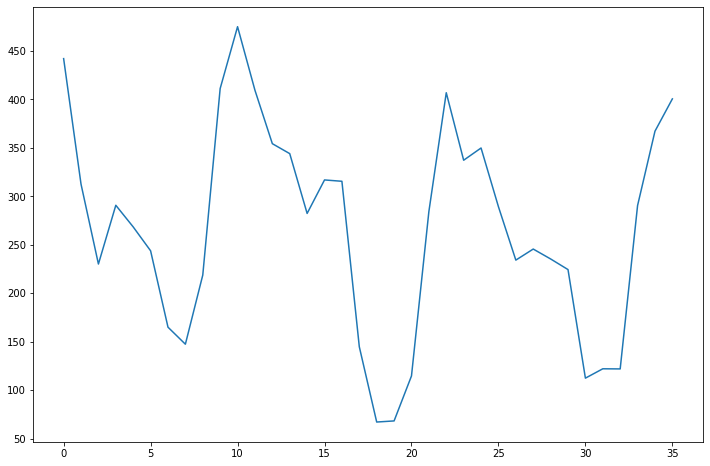

In [4]:
#Interpolate AQI data over 2016, 2017 and 2018
train['Mean'] = train['Mean'].interpolate()
test['Mean'] = test['Mean'].interpolate()
train['Mean'].plot(figsize=(12,8))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'AQI')

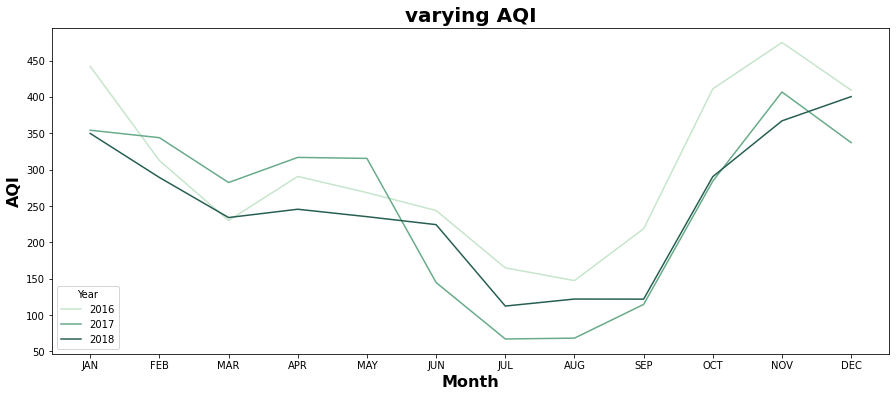

In [5]:
#Plot the seasonal plot for AQI across 2016, 2017 and 2018
variable = 'salinitySurface'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 3)
sns.lineplot(train['Month'], train['Mean'], hue=train['Year'], palette=palette)
ax.set_title('varying AQI', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'AQI')

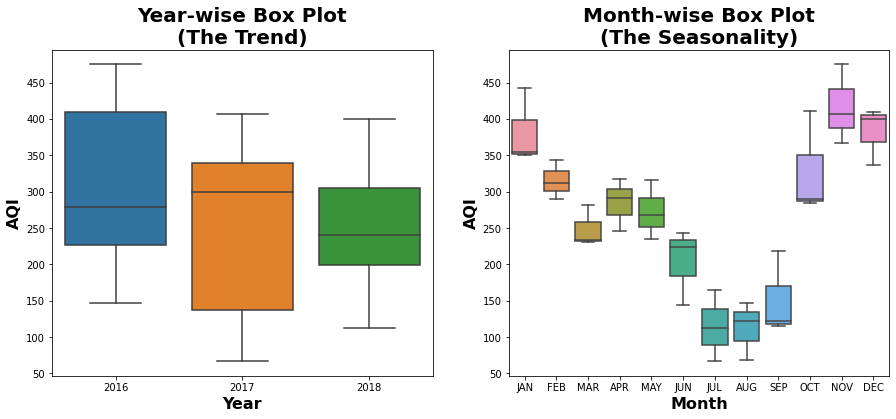

In [6]:
#Plot the year-wise and Month-wise box plot to visualize trend and seasonality
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(train['Year'], train['Mean'], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(train['Month'], train['Mean'], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

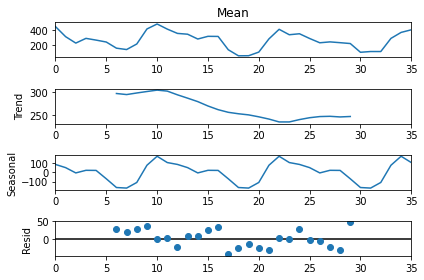

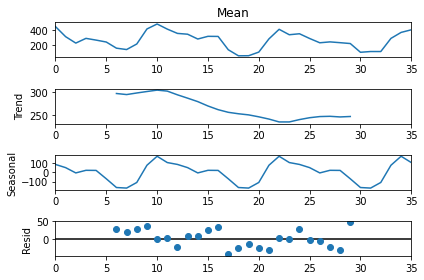

In [7]:
#Decompose time series data into trend, seasonality and residual
res = seasonal_decompose(train['Mean'], model='additive', period=12)
res.plot()

In [9]:
#Check if data is stationary based on ADF statistic
signi = adfuller(train['Mean'])
print('ADF Statistic: %f' % signi[0])
print('p-value: %f' % signi[1])
print('Critical Values:')
for key, value in signi[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.360977
p-value: 0.600835
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


<AxesSubplot:>

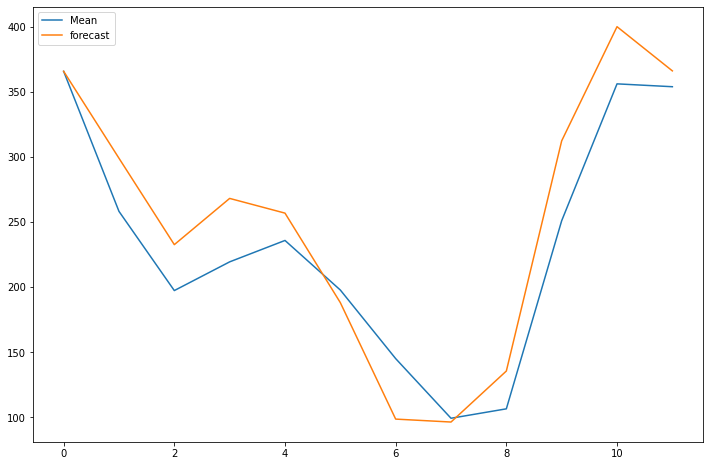

In [10]:
#Prediction and goodness of fit over 2019 data
prediction_2019 = []
prediction_2020 = []
prediction_2019.append(test['Mean'].iloc[0])
prediction_2020.append(lockdown['Mean'].iloc[0])
for i in range(11):
    first = train['Mean'].iloc[i+1] - train['Mean'].iloc[i]
    second = train['Mean'].iloc[i+13] - train['Mean'].iloc[i+12]
    third = train['Mean'].iloc[i+25] - train['Mean'].iloc[i+24]
    mean = (first+second+third)/3
    prediction_2019.append(prediction_2019[-1]+mean)
    prediction_2020.append(prediction_2020[-1]+mean)

test['forecast'] = prediction_2019  
test[['Mean', 'forecast']].plot(figsize=(12, 8))

In [11]:
error = mean_squared_error(test['Mean'], prediction_2019)
print('Persistence MSE: %.3f' % math.sqrt(error))
print(r2_score(test['Mean'], prediction_2019))

Persistence MSE: 34.959
0.8417059926839433


<AxesSubplot:>

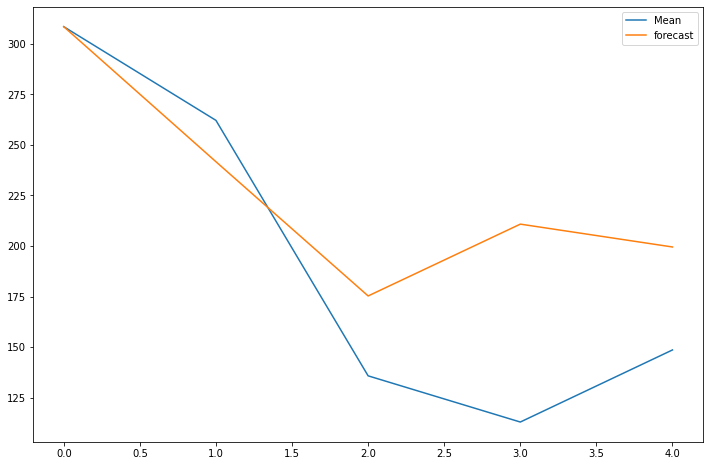

In [12]:
#Predictio
lockdown['forecast'] = prediction_2020  
lockdown[['Mean', 'forecast']].iloc[:5].plot(figsize=(12, 8))

In [13]:
stat, p = wilcoxon(lockdown['forecast'].iloc[1:5], lockdown['Mean'].iloc[1:5])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1.000, p=0.250
